In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
import matplotlib.pyplot as plt


from scipy.stats import loguniform
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import  train_test_split
from plot_metric.functions import BinaryClassification
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold, GridSearchCV




import warnings
warnings.filterwarnings('ignore')

# Read the data

In [2]:
df = pd.read_csv('data/ACME-HappinessSurvey2020.csv')

---

# Data exploration

In [3]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
df.shape

(126, 7)

In [5]:
df.isna().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


- The data includes `126 rows ` and  `7 columns`.
- There are no missing data and all if the features have the right data type.

The meaning of each column has been clarified in the readme file, so I will use that table to name the columns with more understandable titles.

In [7]:
df.rename(columns={"Y": "happy_customer", "X1": "delivered_on_time", "X2": "expected_order"
                  , "X3": "ordered_everything", "X4": "good_price", "X5": "satisfied"
                  , "X6": " easy_app"}, inplace = True)

df.head(2)

,happy_customer,delivered_on_time,expected_order,ordered_everything,good_price,satisfied,easy_app
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3


Let's display the contents of each column

----------------------------------------------------------------------------
delivered_on_time values:
Frequency:[1, 20, 40, 65]
positive rating of delivered_on_time : 83.33333333333334 %
Negative rating of delivered_on_time : 0.7936507936507936 %
----------------------------------------------------------------------------


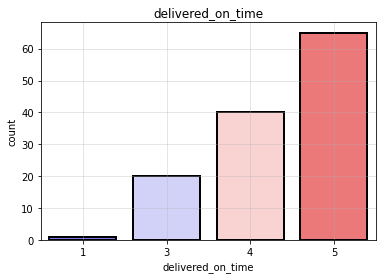

----------------------------------------------------------------------------
expected_order values:
Frequency:[6, 17, 27, 34, 42]
positive rating of expected_order : 18.253968253968253 %
Negative rating of expected_order : 48.41269841269841 %
----------------------------------------------------------------------------


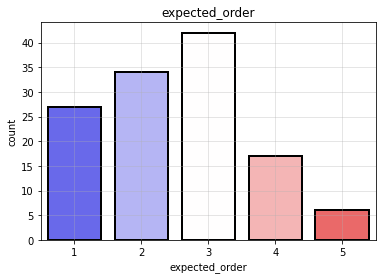

----------------------------------------------------------------------------
ordered_everything values:
Frequency:[7, 14, 17, 33, 55]
positive rating of ordered_everything : 39.682539682539684 %
Negative rating of ordered_everything : 16.666666666666664 %
----------------------------------------------------------------------------


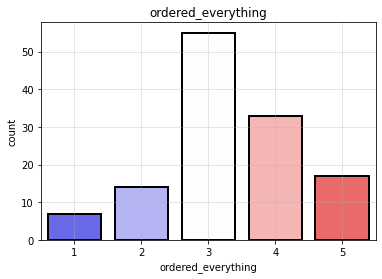

----------------------------------------------------------------------------
good_price values:
Frequency:[2, 5, 25, 41, 53]
positive rating of good_price : 61.904761904761905 %
Negative rating of good_price : 5.555555555555555 %
----------------------------------------------------------------------------


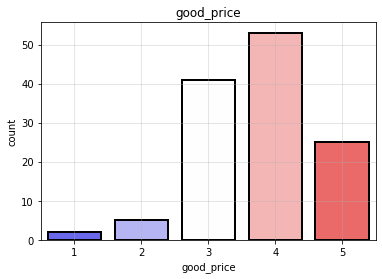

----------------------------------------------------------------------------
satisfied values:
Frequency:[7, 16, 22, 31, 50]
positive rating of satisfied : 64.28571428571429 %
Negative rating of satisfied : 18.253968253968253 %
----------------------------------------------------------------------------


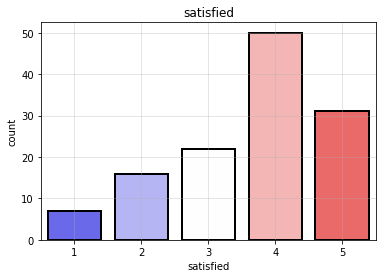

----------------------------------------------------------------------------
 easy_app values:
Frequency:[1, 1, 20, 47, 57]
positive rating of  easy_app : 82.53968253968253 %
Negative rating of  easy_app : 1.5873015873015872 %
----------------------------------------------------------------------------


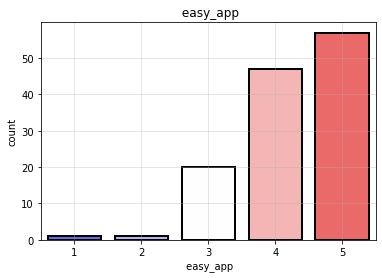

In [8]:
for col in df.columns:
    if col != 'happy_customer':
        sns.countplot(x=col, data=df,  palette='bwr', edgecolor='black', linewidth=2) 
        plt.title(col)
        print('--'*38)
   
        print(f'{col} values:\nFrequency:{sorted(df[col].value_counts())}')
    
        positive = df.loc[(df[col] > 3)].shape[0]
        positive_percentage = positive / df.shape[0]
        negative = df.loc[(df[col] < 3)].shape[0]
        negative_percentage = negative / df.shape[0]
        print('positive rating of' , col,':', positive_percentage * 100, '%')
        print('Negative rating of' , col,':' , negative_percentage * 100, '%')

        print('--'*38)
        plt.grid(alpha=0.4)

        
        plt.show()

**About the rating:**
- 5 = the highest rate.
- 1 = the lowest rate.


You can see all the categories under each column with the number of people, and also above each column the rating ratios are printed as follows to know the opinion of people in general about each service:

- `positive rating` = Percentage of people who rate with `4` or `5` for each feature.
- `Negative rating` = Percentage of people who rate with `1` or `2` for each feature.
- As for `3`, it represents neutrality.


<table >
  <tr>
    <th style = 'text-align: center'>Service</th>
    <th style = 'text-align: center'>Status</th>
    <th style = 'text-align: center'>Reason</th>
  </tr>
  <tr>
    <td style = 'text-align: left'>Delivered on time</td>
    <td style = 'text-align: left'>Keep on</td>
    <td style = 'text-align: left';>High approval rating, low objection.</td>
  </tr>
  <tr>
    <td style = 'text-align: left'>Price</td>
    <td style = 'text-align: left'>Keep on</td>
    <td style = 'text-align: left';>High approval rating, low objection.</td>
  </tr>
  <tr>
    <td style = 'text-align: left'>Easy app</td>
    <td style = 'text-align: left'>Keep on</td>
    <td style = 'text-align: left';>High approval rating, low objection.</td>
  </tr>
  <tr>
    <td style = 'text-align: left'>Satisfied</td>
    <td style = 'text-align: left'>Need to develop</td>
    <td style = 'text-align: left';>Although <span style="color:red">64%</span> of people are satisfied with the service, <span style="color:red">18%</span> is a large percentage of unsatisfied customers.</td>
  </tr>
  <tr>
    <td style = 'text-align: left'>Ordered everything </td>
    <td style = 'text-align: left'>It is necessary to develop</td>
    <td style = 'text-align: left';>It is true that the percentage of dissatisfied customers is <span style="color:red">18%</span>, but it does not satisfy even <span style ="font-weight: bold;">half</span> of the customers.</td>
  </tr>
  <tr>
    <td style = 'text-align: left'>Expected_order</td>
    <td style = 'text-align: left'>It is necessary to develop</td>
    <td style = 'text-align: left';>Almost half of customers are not satisfied with the service.</td>
  </tr>
</table>

**Where is the problem?**

<br>
Well, if the customer doesn't order everything he/she wants, the problem may be in two reasons:


- The website doesn't promote the products, and that's because the recommendation system does not work in the required way.

- The website doesn't offer enough products, and this may be due to two reasons:

    - Displaying many products in different sections, but the portion of each section remains comparatively low.
    
    - The website is specialized in a specific type of product, but it still does not contain the products that the customer wants.
    
<br> 
As for the customer not receiving the same oeder, the problem may lies in:

- The lack of sufficient details about the product on the site, such as pictures, text description, etc.

- The error occurs during the filling and preparation of the product.

<br><br>
Let's show how each column is affected by the customer's satisfaction/dissatisfaction

----------------------------------------------------------------------------
happy_customer:
1    69
0    57
Name: happy_customer, dtype: int64
----------------------------------------------------------------------------


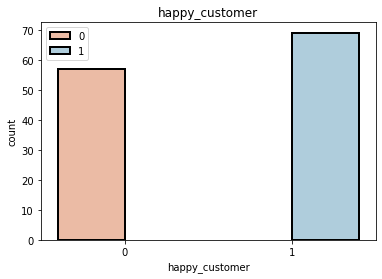

----------------------------------------------------------------------------
delivered_on_time:
5    65
4    40
3    20
1     1
Name: delivered_on_time, dtype: int64
----------------------------------------------------------------------------


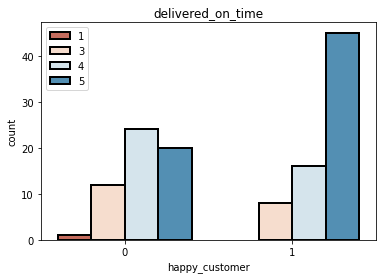

----------------------------------------------------------------------------
expected_order:
3    42
2    34
1    27
4    17
5     6
Name: expected_order, dtype: int64
----------------------------------------------------------------------------


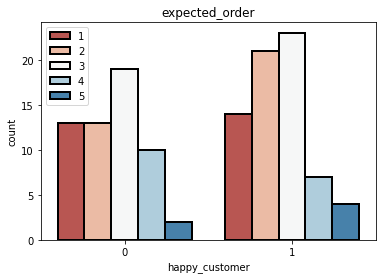

----------------------------------------------------------------------------
ordered_everything:
3    55
4    33
5    17
2    14
1     7
Name: ordered_everything, dtype: int64
----------------------------------------------------------------------------


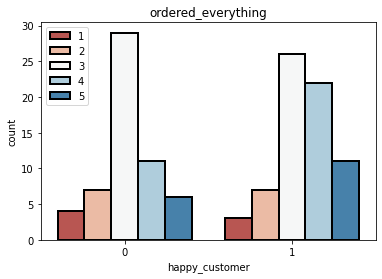

----------------------------------------------------------------------------
good_price:
4    53
3    41
5    25
2     5
1     2
Name: good_price, dtype: int64
----------------------------------------------------------------------------


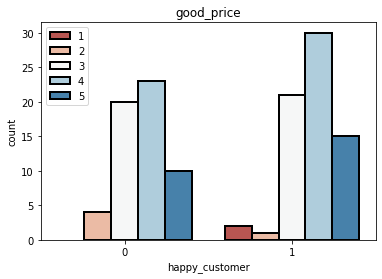

----------------------------------------------------------------------------
satisfied:
4    50
5    31
3    22
2    16
1     7
Name: satisfied, dtype: int64
----------------------------------------------------------------------------


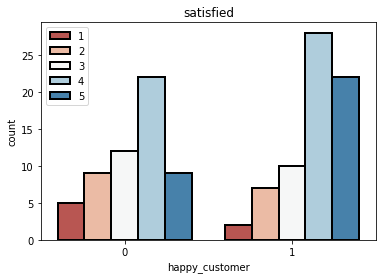

----------------------------------------------------------------------------
 easy_app:
5    57
4    47
3    20
2     1
1     1
Name:  easy_app, dtype: int64
----------------------------------------------------------------------------


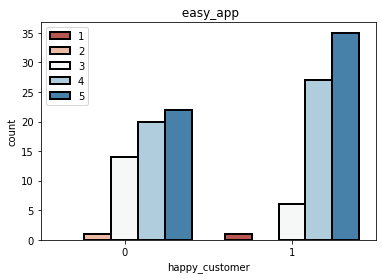

In [9]:
for column in df.columns:
    ax = sns.countplot(df.happy_customer, hue=df[column], palette='RdBu', edgecolor='black', linewidth=2)
    
    plt.title(column)
    plt.legend(loc=2)

    print('--'*38)
    print('{}:\n{}'.format(column, df[column].value_counts()))    
    print('--'*38)

    plt.show()

----------------------------------------------------------------------------
happy_customer:
1    69
0    57
Name: happy_customer, dtype: int64
----------------------------------------------------------------------------


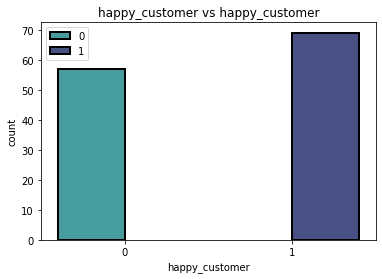

----------------------------------------------------------------------------
delivered_on_time:
5    65
4    40
3    20
1     1
Name: delivered_on_time, dtype: int64
----------------------------------------------------------------------------


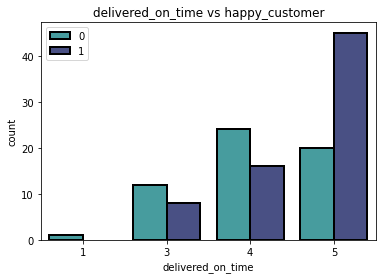

----------------------------------------------------------------------------
expected_order:
3    42
2    34
1    27
4    17
5     6
Name: expected_order, dtype: int64
----------------------------------------------------------------------------


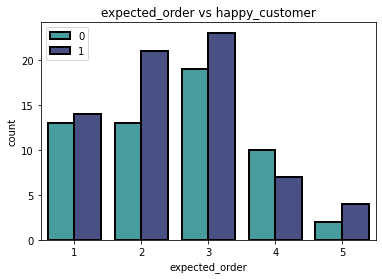

----------------------------------------------------------------------------
ordered_everything:
3    55
4    33
5    17
2    14
1     7
Name: ordered_everything, dtype: int64
----------------------------------------------------------------------------


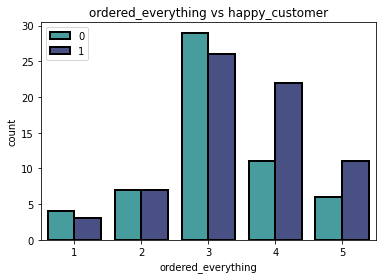

----------------------------------------------------------------------------
good_price:
4    53
3    41
5    25
2     5
1     2
Name: good_price, dtype: int64
----------------------------------------------------------------------------


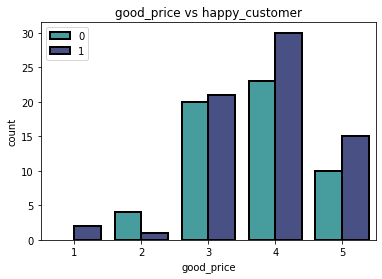

----------------------------------------------------------------------------
satisfied:
4    50
5    31
3    22
2    16
1     7
Name: satisfied, dtype: int64
----------------------------------------------------------------------------


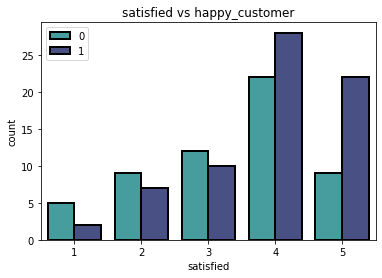

----------------------------------------------------------------------------
 easy_app:
5    57
4    47
3    20
2     1
1     1
Name:  easy_app, dtype: int64
----------------------------------------------------------------------------


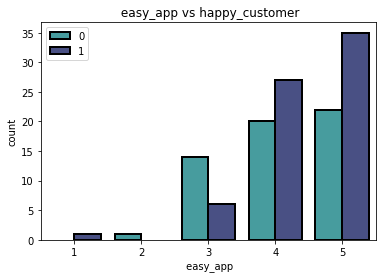

In [10]:
for column in df.columns:
    ax = sns.countplot(df[column], hue=df.happy_customer, palette='mako_r', edgecolor='black', linewidth=2)
    
    plt.title(column+ ' vs happy_customer')
    plt.legend(loc=2)

    print('--'*38)
    print('{}:\n{}'.format(column, df[column].value_counts()))    
    print('--'*38)

    plt.show()


- The data appears to be semi-balanced as there is no significant bias towards one class.
- From the figures, I cannot see a clear relationship between any feature and the customer's dissatisfaction.

---

# Experiment Baseline Model 

In [11]:
X = df.drop("happy_customer", axis=1)
y = df["happy_customer"]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =0)
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [13]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:01<00:00, 15.82it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.73,0.73,0.73,0.71,0.01
PassiveAggressiveClassifier,0.69,0.69,0.69,0.69,0.02
NearestCentroid,0.69,0.69,0.69,0.69,0.01
LGBMClassifier,0.65,0.65,0.65,0.65,0.40
BernoulliNB,0.62,0.62,0.62,0.61,0.01
SGDClassifier,0.62,0.62,0.62,0.62,0.01
GaussianNB,0.62,0.62,0.62,0.61,0.02
LogisticRegression,0.62,0.62,0.62,0.59,0.02
LinearDiscriminantAnalysis,0.58,0.58,0.58,0.54,0.07


The highest three model scores are `Nearest Centroid`, `Passive Aggressive Classifier` and `Perceptron`, so I will try to improve their scores through `Grid Search ` and `Randomized Search`.

---

## Nearest Centroid Model

with `Randomized Search`

Best Hyperparameters: {'metric': 'manhattan', 'shrink_threshold': 9.61853358240905}


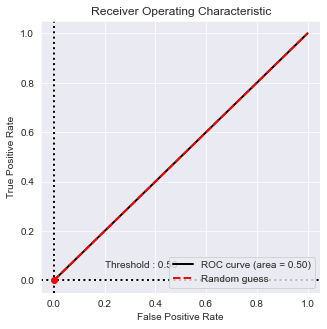

In [14]:

# define model
model = NearestCentroid()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['shrink_threshold'] = loguniform(1e-5, 10)
space['metric'] = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']


# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train_s, y_train)
# summarize result
print('Best Hyperparameters: %s' % result.best_params_)


y_pred = result.predict(X_test_s)
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

with `Grid Search`

Fitting 10 folds for each of 42 candidates, totalling 420 fits
Config: {'metric': 'cityblock', 'shrink_threshold': 0.0001}


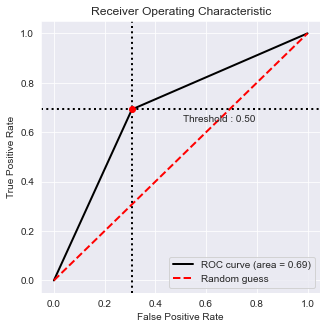

In [15]:
# define model
model = NearestCentroid()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
# define grid
grid = {
    'metric' : ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan'], 
        'shrink_threshold' : [0.0001, 0.001, 0.01, 1.0, 2.0, 3.0, 10.0]
       }
# define search
search = GridSearchCV(model, grid, scoring='roc_auc', cv=cv, n_jobs=-1, return_train_score=True, verbose=1)
# perform the search
results = search.fit(X_train_s, y_train)
# summarize
print('Config: %s' % results.best_params_)
# summarize all


y_pred = results.predict(X_test_s)
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

---

## Passive Aggressive Classifier Model

with `Randomized Search`

Best Score: 0.6150277777777778
Best Hyperparameters: {'C': 0.00020960679477077847, 'fit_intercept': False, 'loss': 'squared_hinge', 'max_iter': 37.29824582733331, 'shuffle': True, 'tol': 0.00033086104503821567}


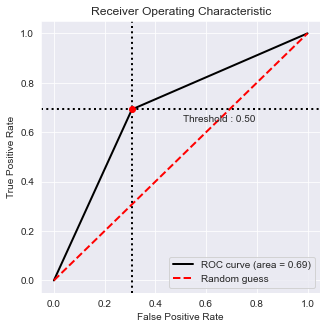

In [16]:

# define model
model = PassiveAggressiveClassifier()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['C'] = loguniform(1e-5, 10)
space['loss'] = ['squared_hinge','hinge']
space['fit_intercept'] = [True, False]
space['max_iter'] = loguniform(1, 1000)
space['tol'] = loguniform(1e-5, 10)
space['shuffle'] = [True, False]


# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train_s, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


y_pred = results.predict(X_test_s)
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

with `Grid Search`

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
best score: 0.599
Config: {'C': 0.001, 'loss': 'squared_hinge', 'max_iter': 200, 'tol': 0.01}


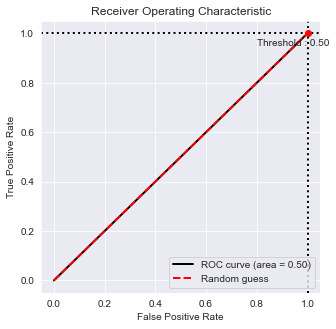

In [17]:
# define model
model = PassiveAggressiveClassifier()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)
# define grid
grid = {
    'loss' : ['squared_hinge','hinge'], 
        'C' : [0.0001, 0.001, 0.01, 1.0, 2, 3, 10],
        'max_iter' : [10, 100, 200],
        'tol' : [0.0001, 0.001, 0.01, 0.1],
       }
# define search
search = GridSearchCV(model, grid, scoring='roc_auc', cv=cv, n_jobs=-1, return_train_score=True, verbose=1)
# perform the search
results = search.fit(X_train_s, y_train)
# summarize
print('best score: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)
# summarize all


y_pred = results.predict(X_test_s)
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

---

# Perceptron Model

with `Randomized Search`

Best Score: 0.6211388888888888
Best Hyperparameters: {'alpha': 0.0837691571571245, 'eta0': 0.0013597686426122747, 'fit_intercept': True, 'max_iter': 6.859227795943493, 'penalty': 'elasticnet', 'shuffle': False, 'tol': 0.008702374738959011}


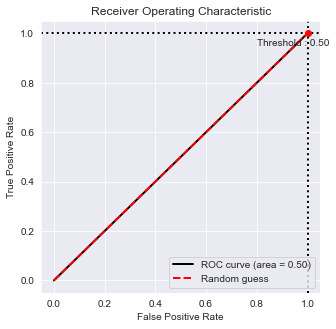

In [18]:

# define model
model = Perceptron()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['alpha'] = loguniform(1e-5, 10)
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['fit_intercept'] = [True, False]
space['max_iter'] = loguniform(1, 1000)
space['tol'] = loguniform(1e-5, 10)
space['shuffle'] = [True, False]
space['eta0'] = loguniform(1e-5, 10)
space['tol'] = loguniform(1e-5, 10)
space['tol'] = loguniform(1e-5, 100)

# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train_s, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


y_pred = results.predict(X_test_s)
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

with `Grid Search`

Fitting 10 folds for each of 1152 candidates, totalling 11520 fits
best score: 0.612
Config: {'alpha': 0.01, 'eta0': 1, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.01}


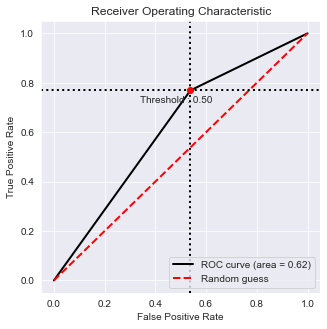

In [19]:
# define model
model = Perceptron()

# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

# define grid
grid = {'penalty' : ['l2','l1','elasticnet', None], 
        'alpha' : [0.0001, 0.001, 0.01, 1.0],
        'max_iter' : [10, 100, 1000],
        'tol' : [0.0001, 0.001, 0.01, 0.1],
        'eta0' : [1, 2, 3, 4, 5, 6]
       }

# define search
search = GridSearchCV(model, grid, scoring='roc_auc', cv=cv, n_jobs=-1, return_train_score=True, verbose=1)

# perform the search
results = search.fit(X_train_s, y_train)

# summarize
print('best score: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

y_pred = results.predict(X_test_s)
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

best score: 0.573
Config: {'eta0': 4, 'penalty': 'elasticnet'}


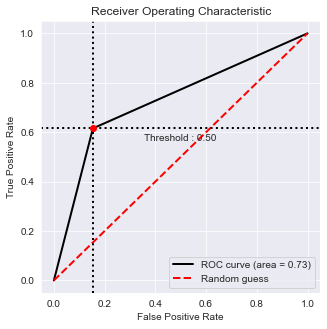

In [20]:
# define model
model = Perceptron()

# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = {
    'penalty' : ['l2','l1','elasticnet', None], 
     'eta0' : [2, 3, 4, 5, 6],
}

# define search
search = GridSearchCV(model, grid, scoring='roc_auc', cv=cv)

# perform the search
results = search.fit(X_train_s, y_train)

# summarize
print('best score: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

y_pred = results.predict(X_test_s)
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

Roc Auc Mean Score: 0.609 


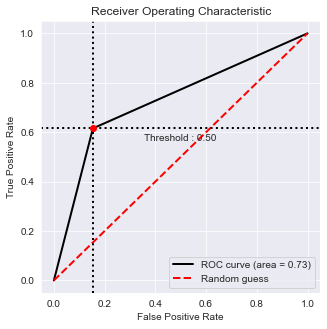

In [21]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = Perceptron(penalty='elasticnet', eta0=4).fit(X_train_s, y_train)

# evaluate model
scores = cross_val_score(model, X_train_s, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
print('Roc Auc Mean Score: %.3f ' % (mean(scores)))
y_pred = model.predict(X_test_s)
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

The last model was the best among them, so I will print the confusion matrix so that I can see the model's performance for each class, and I will also see what feature affected the model the most.

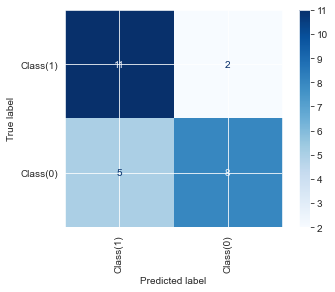

In [22]:
class_names = ['Class(1)', 'Class(0)']
disp = plot_confusion_matrix(model, X_test_s, y_test, display_labels=class_names,
                             cmap=plt.cm.Blues, xticks_rotation='vertical')

It seems that the performance of the model on `Class 1` is better than `Class 0`, and since the data was almost balanced, I suggest that, it's due to the fact that there are not enough indications for `Class 0`, so perhaps adding some features will be useful in increasing the accuracy.

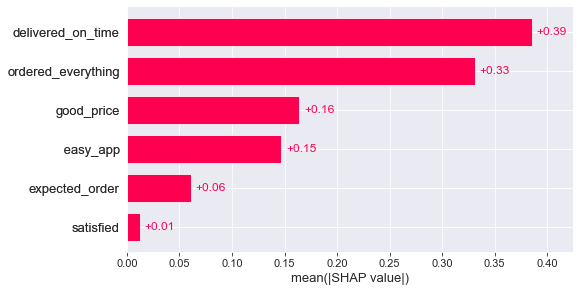

In [23]:
explainer = shap.Explainer(model.predict, X_train_s)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)


The two features that influenced the model the most are `delivered_on_time` and `ordered_everything`.

<br><br>
**These questions can be added to the survey later:**

If the customer's answer is `not satisfied` with the order in general, there should be options like:
- Which part of the order process did not satisfy you? (the product did not reach you on time ... etc.)

If the customer's answer is `different order` has been delivered, there should be options like:
- Was the text description not clear or sufficient?
- Was the product image different from what you received?
- Did you order a product and received the same product, but in a different size, type or brand?
- Have you ordered a product and received a completely different one?
- Did you order something and it never arrived?

---